In [1]:
import gensim.downloader as api
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA
# from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer

2025-04-19 14:01:44.974071: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-19 14:01:44.977238: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-19 14:01:45.028106: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-19 14:01:45.029303: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-19 14:01:45.910904: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [89]:
csv = "../../data/cleaned/final_clean_data1.csv"
df = pd.read_csv(csv)

In [90]:
df.size

3419

In [91]:
heart_keywords = [
    'aorta','aortic','arrhythmia','artery','atrial','atrium','bradycardia','cardiac',
    'cardiac_border','cardiac_enlargement','cardiomediastinal','cardiomegalia','cardiomegaly',
    'cardiopulmonary','cardiothoracic','cardiovascular','congestion','congestive','coronary','enlargement',
    'heart','heart failure','heart_size','hypertension','hypotension','infarction','ischemia','mediastinal',
    'mediastinum','myocardial','palpitation','pericardial','pericardium','silhouette','stenosis',
    'tachycardia','valve','vascular','vascular_congestion','vascularity','vasculature','vein','ventricle',
    'ventricular'

]
lung_keywords = [
    'airspace','alveolar','atelectasis','basilar','bibasilar','bilateral','bilateral_pulmonary_nodule',
    'breath','bronchi','bronchial','bronchovascular','cardiopulmonary','chest','consolidation','copd',
    'costophrenic','diaphragm','dyspnea','edema','effusion','emphysema','fibrosis','findings','granulomatous',
    'hemidiaphragm','hemothorax','hilar','hyperexpanded','hyperinflation','infiltrate','infiltrates','infiltration',
    'interstitial','lobar','lobe','lobes','lower_lobe','lung','lungs','mass','mediastinal','midlung','nodular',
    'nodule','opacities','opacity','pain','parenchymal','pleura','pleural','pneumonia','pneumothorax','pulmonary',
    'radiograph','scarring','shortness','spasm','thorax','trachea','tuberculosis','unilateral'

]

def assign_subject_code(text):
    text = str(text).lower()  
    heart_score = sum(1 for word in heart_keywords if re.search(r'\b' + re.escape(word) + r'\b', text))
    lung_score = sum(1 for word in lung_keywords if re.search(r'\b' + re.escape(word) + r'\b', text))

    if lung_score > heart_score:
        return 1  # Poumon
    elif heart_score > lung_score:
        return 2  # Cœur
    else:
        return 0  # Inconnu

df['sujet'] = df['combined_text'].apply(assign_subject_code)

In [92]:
# Séparer les datasets
df_lung = df[df['sujet'] == 1].reset_index(drop=True)
df_heart = df[df['sujet'] == 2].reset_index(drop=True)

# (Optionnel) Afficher les tailles
print(f" Poumon : {len(df_lung)} lignes")
print(f" Cœur : {len(df_heart)} lignes")

 Poumon : 2862 lignes
 Cœur : 305 lignes


In [80]:
pd.set_option('display.max_colwidth', None)
df_lung

,combined_text,sujet
0,cardiac silhouette mediastinum size within normal limit pulmonary edema focal consolidation pleural effusion evidence pneumothora normal chest,1
1,cardiomediastinal silhouette within normal limit size contour lung normally inflated without evidence focal airspace disease pleural effusion pneumothora stable calcified granuloma within right upper lung acute bone abnormality acute cardiopulmonary process,1
2,increased_opacity within right_upper_lobe possible mass associated area atelectasis focal_consolidation cardiac silhouette within normal limit opacity left midlung overlying posterior left_5th_rib_may represent_focal_airspace_disease pleural effusion pneumothora acute bone abnormality increased_opacity right_upper_lobe associated atelectasis may_represent focal_consolidation mass lesion atelectasis recommend chest computed tomography evaluation opacity overlying left_5th_rib_may represent_focal_airspace_disease,1
3,interstitial marking diffusely prominent throughout lung heart size normal pulmonary normal diffuse fibrosis visible focal acute disease,1
4,heart size pulmonary vascularity appear within normal limit retrocardiac_soft_tissue_density present appears air within could suggest represents hiatal_hernia vascular calcification noted calcified granuloma seen interval development bandlike_opacity left lung base may represent atelectasis pneumothora pleural effusion seen osteopenia present spine retrocardiac_soft_tissue_density appearance_suggests hiatal_hernia left base bandlike_opacity appearance_suggests atelectasis,1
...,...,...
2857,heart size normal lung clear normal pneumonia effusion edema pneumothora adenopathy nodule mass normal chest evidence tuberculosis,1
2858,lung clear cardiomediastinal silhouette within normal limit pneumothora pleural effusion negative chest,1
2859,sternotomy suture bypass graft placed interval lung remain clear epanded infiltrates pulmonary normal post operative chest acute disease,1
2860,calcified mediastinal focal area consolidation heart size within normal limit pleural effusion evidence pneumothora degenerative change thoracic spine acute cardiopulmonary abnormality,1


In [81]:
df_heart

,combined_text,sujet
0,lung clear epanded heart mediastinum normal active disease,2
1,heart top normal size mediastinum unremarkable lung clear acute disease,2
2,heart size mediastinal contour appear within normal limit blunting_right lateral costophrenic_sulcus_could_secondary small effusion_versus_scarring_focal airspace_consolidation pneumothora acute bony abnormality blunting_right costophrenic_sulcus_could_secondary effusion_versus_scarring_focal airspace_consolidation,2
3,cardiomediastinal silhouette vasculature within_normal_limit size contour lung normally inflated clear osseous structure within_normal_limit patient age acute radiographic cardiopulmonary process,2
4,heart lung interval lung clear epanded heart mediastinum normal active disease,2
...,...,...
300,heart normal size mediastinum unremarkable lung clear acute disease,2
301,heart size cardiomediastinal silhouette pulmonary vasculature within normal limit infiltrates effusion pneumothora acute cardiopulmonary process,2
302,heart top normal size mediastinum stable lung clear borderline cardiomegaly without acute disease,2
303,heart lung interval lung clear epanded heart mediastinum normal active disease,2


In [82]:
df

,combined_text,sujet
0,cardiac silhouette mediastinum size within normal limit pulmonary edema focal consolidation pleural effusion evidence pneumothora normal chest,1
1,cardiomediastinal silhouette within normal limit size contour lung normally inflated without evidence focal airspace disease pleural effusion pneumothora stable calcified granuloma within right upper lung acute bone abnormality acute cardiopulmonary process,1
2,lung clear epanded heart mediastinum normal active disease,2
3,increased_opacity within right_upper_lobe possible mass associated area atelectasis focal_consolidation cardiac silhouette within normal limit opacity left midlung overlying posterior left_5th_rib_may represent_focal_airspace_disease pleural effusion pneumothora acute bone abnormality increased_opacity right_upper_lobe associated atelectasis may_represent focal_consolidation mass lesion atelectasis recommend chest computed tomography evaluation opacity overlying left_5th_rib_may represent_focal_airspace_disease,1
4,interstitial marking diffusely prominent throughout lung heart size normal pulmonary normal diffuse fibrosis visible focal acute disease,1
...,...,...
3414,lung clear cardiomediastinal silhouette within normal limit pneumothora pleural effusion negative chest,1
3415,sternotomy suture bypass graft placed interval lung remain clear epanded infiltrates pulmonary normal post operative chest acute disease,1
3416,calcified mediastinal focal area consolidation heart size within normal limit pleural effusion evidence pneumothora degenerative change thoracic spine acute cardiopulmonary abnormality,1
3417,cardiomediastinal silhouette demonstrates normal heart size tortuosity atherosclerosis thoracic aorta focal consolidation pneumothora pleural effusion acute bony abnormality identified multilevel degenerative disc disease thoracic spine noted acute cardiopulmonary abnormality,2


In [83]:
def contamination_function_bis(data1, data2, contamination_rate=0.2):
    """
    Fonction qui génère des anomalie dans notre jeu de données data1, en injectant des donnée de data2.
    
    - data1 : Corpus de données sain
    - data2 : Corpus de données considérées "anomalie"
    - contamination_rate : le taux de document contaminé par rapport a la taille de data1
    
    retourne un nouveau corpus de données avec des anomalies + les indices des anomalies
    """
    contamination_log = []
    
    #on contamine % des documents dans data1 
    df_size = max(1, int(len(data1) * contamination_rate))  
    selected_indices = random.sample(range(len(data1)), df_size)
    
    for i in selected_indices:
        base_text = data1[i]
        new_text = random.choice(data2)
        data1[i] = new_text  # remplacement de la ligne 

        # un log pour surveiller le fonctionnement de la fonction (à ajouter dans le return)
        contamination_log.append({
            "base_text": base_text,  # le texte original avant remplacement
            "contaminated_text": new_text,  # le texte après remplacement
            "index_replaced": i  # l'index de la ligne modifiée
        })

    return data1, selected_indices

In [84]:
new_df, indice = contamination_function_bis(df_lung['combined_text'], df_heart['combined_text'] )

/tmp/ipykernel_19563/815275547.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1[i] = new_text  # remplacement de la ligne


In [85]:
def vetorisation_sbert(data, indice_anomalie=None):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    vecteurs = model.encode(data)
    vecteurs = np.array(vecteurs)

    tsne = TSNE(n_components=2, random_state=42)  
    vecteurs_2d = tsne.fit_transform(vecteurs)  
    
    # couleurs des points ( rouge : anomalie, bleu : noraml)
    couleurs = ['b'] * len(data)
    if indice_anomalie:
        for i in indice_anomalie:
            if 0 <= i < len(data): 
                couleurs[i] = 'r'

    plt.figure(figsize=(40, 20)) 
    plt.scatter(vecteurs_2d[:, 0], vecteurs_2d[:, 1], c=couleurs, marker='o') 

    plt.title("Représentation graphique des documents vectorisés")
    plt.grid(True)
    #plt.savefig("output.jpg")
    plt.show()
    return vecteurs

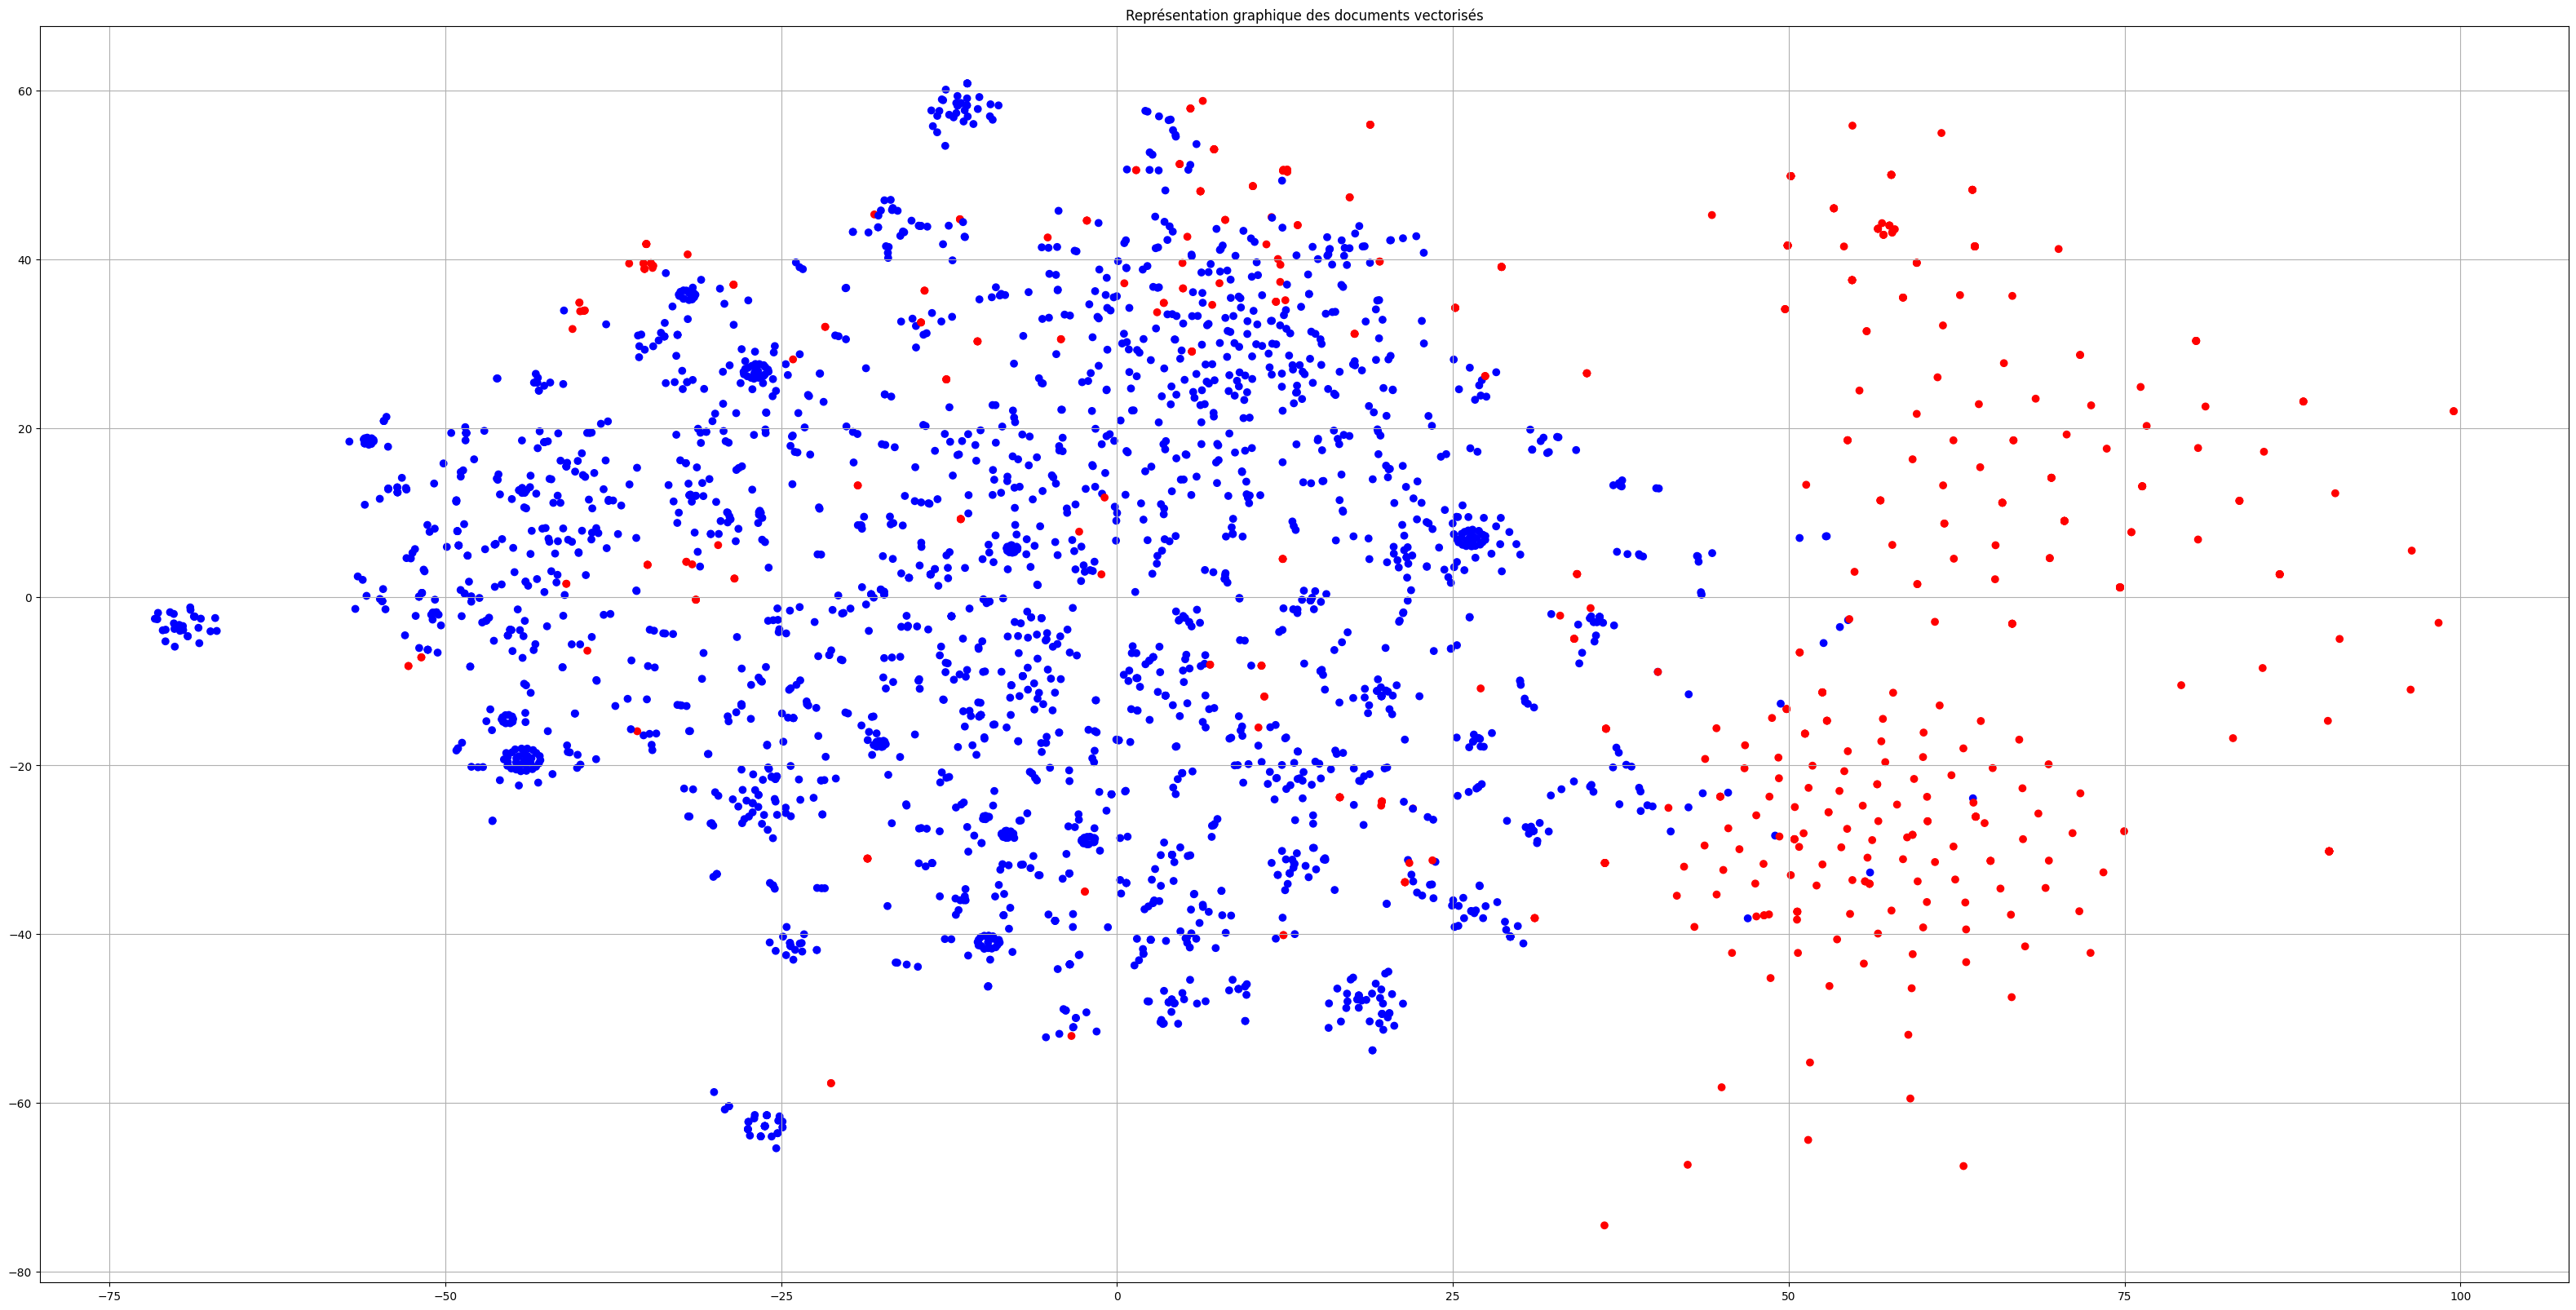

array([[ 0.08131562,  0.01867447,  0.0114061 , ..., -0.01223775,
        -0.05117593,  0.03751218],
       [ 0.08086951,  0.0399133 ,  0.01529451, ...,  0.0049861 ,
        -0.00064547,  0.03883004],
       [ 0.03652819,  0.03813877, -0.00274674, ...,  0.0195469 ,
        -0.04018005,  0.08081686],
       ...,
       [ 0.01492713,  0.06129958,  0.02432553, ..., -0.07227294,
         0.01168536,  0.03520867],
       [ 0.15610385, -0.04686337, -0.006222  , ...,  0.01269923,
        -0.01770326, -0.0500242 ],
       [ 0.11009462,  0.00219571, -0.0090332 , ..., -0.02004806,
        -0.03694163,  0.0073583 ]], dtype=float32)

In [86]:
vetorisation_sbert(new_df, indice)

In [87]:
new_df.to_csv('../../data/contaminated/contaminated_data_bis.csv', index=False)

In [88]:
np.save("../../data/contaminated/indices_anomalies_bis.npy", indice)